# DISCLAIMER
Please refer to the README.md file in a professional manner for the complete and up-to-date information. The information provided here is for reference purposes only and may not be accurate or current.

# Importing Libraries
This cell imports essential libraries for portfolio optimization using quantum computing. 
- `pandas` and `numpy` are used for data manipulation and numerical operations.
- `matplotlib.pyplot` is used for plotting.
- `qiskit` modules are used for quantum algorithms and financial applications.

Please refer to README for the version of packages.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from qiskit.circuit.library import TwoLocal
from qiskit.result import QuasiDistribution
from qiskit.primitives import Sampler
from qiskit_algorithms import NumPyMinimumEigensolver, QAOA, SamplingVQE
from qiskit_algorithms.optimizers import COBYLA
from qiskit_finance import QiskitFinanceError
from qiskit_finance.applications.optimization import PortfolioOptimization
from qiskit_finance.data_providers import YahooDataProvider
from qiskit_optimization.algorithms import MinimumEigenOptimizer
import datetime



# Fetching and Plotting Ticker Data
This function `get_ticker_data()` fetches historical stock data for Microsoft (MSFT), Google (GOOG), and Amazon (AMZN) from Yahoo Finance. 
It then plots their historical performance.

CNT 0  S MSFT 
Data at 0 for MSFT is Date
2015-01-02     40.305370
2015-01-05     39.934719
2015-01-06     39.348595
2015-01-07     39.848518
2015-01-08     41.020798
                 ...    
2020-12-22    217.288681
2020-12-23    214.455414
2020-12-24    216.134018
2020-12-28    218.278397
2020-12-29    217.492432
Name: Adj Close, Length: 1509, dtype: float64
CNT 1  S GOOG 
Data at 1 for GOOG is Date
2015-01-02    26.138908
2015-01-05    25.594027
2015-01-06    25.000832
2015-01-07    24.958000
2015-01-08    25.036694
                ...    
2020-12-22    86.077049
2020-12-23    86.520546
2020-12-24    86.843674
2020-12-28    88.703560
2020-12-29    87.836044
Name: Adj Close, Length: 1509, dtype: float64
CNT 2  S AMZN 
Data at 2 for AMZN is Date
2015-01-02     15.426000
2015-01-05     15.109500
2015-01-06     14.764500
2015-01-07     14.921000
2015-01-08     15.023000
                 ...    
2020-12-22    160.326004
2020-12-23    159.263504
2020-12-24    158.634506
2020-12-28    164.

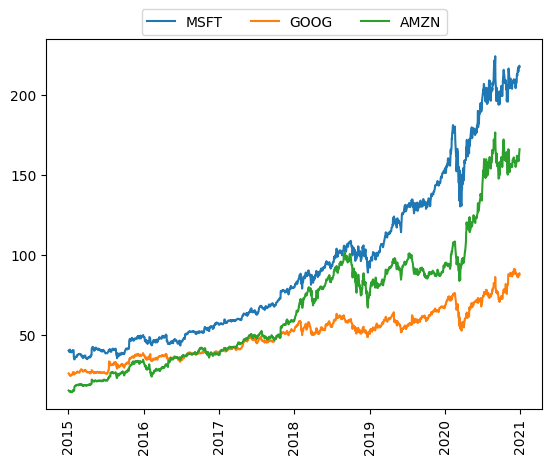

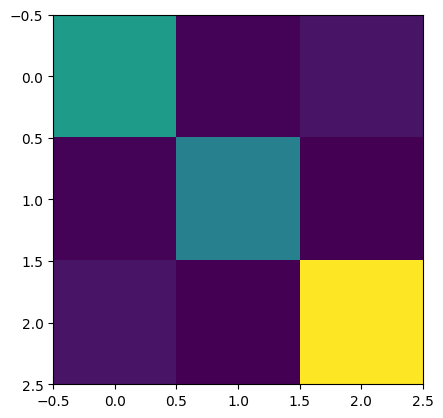

In [11]:
def get_ticker_data():
    """
    Retrieves ticker data from Yahoo Finance for the specified tickers and time range.
    
    Returns:
        YahooDataProvider: An instance of the YahooDataProvider class containing the retrieved data.
    """
    try:
        data = YahooDataProvider(
            tickers=["MSFT", "GOOG", "AMZN"],
            start=datetime.datetime(2015, 1, 1),
            end=datetime.datetime(2020, 12, 30),
        )
        data.run()
        for (count, s) in enumerate(data._tickers):
            print(f"CNT {count}  S {s} ")
            print(f"Data at {count} for {s} is {data._data[count]}")
            plt.plot(data._data[count], label=s)
        plt.legend(loc="upper center", bbox_to_anchor=(0.5, 1.1), ncol=3)
        plt.xticks(rotation=90)
        plt.show()
    except QiskitFinanceError as ex:
        data = None
        print(ex)
    return data

# Defining Portfolio Optimization Problem
This cell sets up the portfolio optimization problem using the `PortfolioOptimization` class from Qiskit Finance.

### Quadratic Program Details:
The quadratic program (QP) models the portfolio optimization problem, which aims to balance risk and return while adhering to constraints like budget and risk tolerance.

### Objective Function:
The objective function of the quadratic program is:

\[ \text{minimize} \quad \frac{1}{2} \mathbf{x}^T \mathbf{Q} \mathbf{x} - q \cdot \mathbf{c}^T \mathbf{x} \]

where:
- \( \mathbf{Q} \) is the covariance matrix of asset returns (denoted as `sigma` in the code).
- \( \mathbf{c} \) is the vector of expected returns (denoted as `mu` in the code).
- \( \mathbf{x} \) is the vector of asset allocations (decision variables).
- \( q \) is the risk factor balancing risk and return.

### Constraints:
The quadratic program includes the following constraints:
1. **Budget Constraint**: Ensures the sum of the asset weights equals the total budget.
2. **Non-Negativity**: Ensures asset weights are non-negative, prohibiting short selling.

### Code Implementation:
The code configures an instance of the `PortfolioOptimization` class and converts it into a quadratic program using the `to_quadratic_program` method.

In [12]:
data = get_ticker_data()
sigma = data.get_period_return_covariance_matrix()
mu = data.get_period_return_mean_vector()
plt.imshow(sigma, interpolation="nearest")
plt.show()
num_assets = 3
q = 0.2  # set risk factor
budget = 2  # set budget  # set parameter to scale the budget penalty term
portfolio = PortfolioOptimization(
    expected_returns=mu, covariances=sigma, risk_factor=q, budget=budget
)
qp = portfolio.to_quadratic_program()
qp

<QuadraticProgram: minimize 6.149875353744738e-05*x_0^2 + 8.684003153742987e-0..., 3 variables, 1 constraints, 'Portfolio optimization'>

# Printing Optimization Results
The `print_result` function is updated to print the expected return and risk (standard deviation) for each portfolio allocation.
It includes detailed information about portfolio allocations, expected returns, risks, and the stocks involved.

In [5]:
def print_result(result, mu, sigma, tickers):
    """
    Prints the optimization result, including the optimal selection, value, and the full result.

    Parameters:
    - result: The optimization result object.
    - mu: The expected returns.
    - sigma: The covariance matrix.
    - tickers: The list of stock tickers.

    Returns:
    None
    """
    selection = result.x
    value = result.fval
    print("Optimal: selection {}, value {:.4f}".format(selection, value))

    eigenstate = result.min_eigen_solver_result.eigenstate
    probabilities = (
        eigenstate.binary_probabilities()
        if isinstance(eigenstate, QuasiDistribution)
        else {k: np.abs(v) ** 2 for k, v in eigenstate.to_dict().items()}
    )
    print("\n----------------- Full result ---------------------")
    print("Selection\tExpected Return\tRisk (Std. Dev.)\tProbability\tStocks")
    print("---------------------------------------------------")
    probabilities = sorted(probabilities.items(), key=lambda x: x[1], reverse=True)

    for binary_str, prob in probabilities:
        if prob > 0.01:  # Filter out very low probability solutions
            weights = np.array([int(bit) for bit in binary_str])[::-1]
            if np.sum(weights) == 0:
                continue  # Skip the zero-weight portfolio
            weights = weights / np.sum(weights)  # Normalize weights to sum to 1
            portfolio_return = np.dot(weights, mu)
            portfolio_risk = np.sqrt(np.dot(weights.T, np.dot(sigma, weights)))
            included_tickers = [tickers[i] for i in range(len(tickers)) if weights[i] > 0]
            annotation = ', '.join(included_tickers)
            print("{:<10s}\t{:.4f}\t\t{:.4f}\t\t{:.4f}\t{}".format(binary_str, portfolio_return, portfolio_risk, prob, annotation))

# Quantum Approximate Optimization Algorithm (QAOA)

Quantum Approximate Optimization Algorithm (QAOA) is a hybrid quantum-classical algorithm designed for solving combinatorial optimization problems.

QAOA leverages quantum circuits to explore complex solution spaces and classical optimization to refine parameters.

QAOA combines quantum operations and classical optimization to approximate solutions to optimization problems. It uses a parameterized quantum circuit to encode the problem and a classical optimizer to adjust the parameters of the circuit.

### Initialization
The quantum state is initialized to a superposition of all possible states using Hadamard gates:
\`[
| \psi_0 \rangle = H^{\otimes n} | 0 \rangle^{\otimes n}
\`]
where \( H \) is the Hadamard gate applied to each qubit. This creates an equal superposition over all \( 2^n \) possible states.

### Problem Hamiltonian (\( U(C, \gamma) \))
The problem Hamiltonian encodes the cost function of the optimization problem into the quantum state:
\[
U(C, \gamma) = e^{-i \gamma C}
\]
Here, \( C \) represents the cost function as a Hamiltonian. The parameter \( \gamma \) controls the evolution under this Hamiltonian.

### Mixing Hamiltonian (\( U(B, \beta) \))
The mixing Hamiltonian allows the quantum state to explore the solution space:
\[
U(B, \beta) = e^{-i \beta B}
\]
Typically, \( B \) is the sum of Pauli-X operators:
\[
B = \sum_{i=1}^n X_i
\]
The parameter \( \beta \) controls the evolution under the mixing Hamiltonian.

### Quantum State Evolution
The quantum state evolves through \( p \) layers of alternating Hamiltonians:
\[
| \psi(\gamma, \beta) \rangle = \prod_{k=1}^{p} U(B, \beta_k) U(C, \gamma_k) | \psi_0 \rangle
\]
Here, \( \gamma \) and \( \beta \) are parameters that are iteratively optimized to minimize the cost function. Each layer applies the problem and mixing Hamiltonians sequentially.

### Quantum Circuit Diagram
![Image](QAOA_schematic.png)

1. **Hadamard Gates**: Initialize the qubits into a superposition.
2. **Cost Function Layer**: Applies the problem Hamiltonian \( U(C, \gamma) \).
3. **Mixing Layer**: Applies the mixing Hamiltonian \( U(B, \beta) \).

## Classical Optimization

### Parameter Optimization
A classical optimizer is used to adjust the parameters \( \gamma \) and \( \beta \) to minimize the expected value of the cost function:
\[
\langle C \rangle = \langle \psi(\gamma, \beta) | C | \psi(\gamma, \beta) \rangle
\]

The optimization aims to find the parameter values that result in the lowest expectation value for the cost function, corresponding to the optimal solution to the problem.

## References
- [QAOA Overview in Qiskit Documentation](https://qiskit.org/documentation/stable/0.25/apidoc/qiskit.algorithms.QAOA.html)
- [QAOA Theory and Applications](https://qiskit.org/textbook/ch-applications/qaoa.html)
- [QAOA Example in Qiskit Textbook](https://github.com/Qiskit/textbook/blob/main/notebooks/ch-applications/qaoa.ipynb)



In [6]:
from qiskit_ibm_provider import IBMProvider
from qiskit_algorithms.utils import algorithm_globals

def get_least_busy_backend():
    provider = IBMProvider()
    backends = provider.backends(filters=lambda x: x.configuration().n_qubits >= 5 and not x.configuration().simulator)
    least_busy_backend = min(backends, key=lambda x: x.status().pending_jobs)
    return least_busy_backend

algorithm_globals.random_seed = 1234
cobyla = COBYLA()
cobyla.set_options(maxiter=500)
qaoa_mes = QAOA(sampler=Sampler(), optimizer=cobyla, reps=10)
qaoa = MinimumEigenOptimizer(qaoa_mes)
result = qaoa.solve(qp)

Allocation: [0.5 0.5 0. ], Return: 0.0011096105687202983, Risk: 0.0160439471086446, Probability: 0.3326523892304735, Stocks: MSFT, GOOG
Allocation: [0.5 0.  0.5], Return: 0.001518929251047065, Risk: 0.016858509521637262, Probability: 0.3339399132630586, Stocks: MSFT, AMZN
Allocation: [0.  0.5 0.5], Return: 0.001356540307288674, Risk: 0.016585872054464806, Probability: 0.3334070788480182, Stocks: GOOG, AMZN


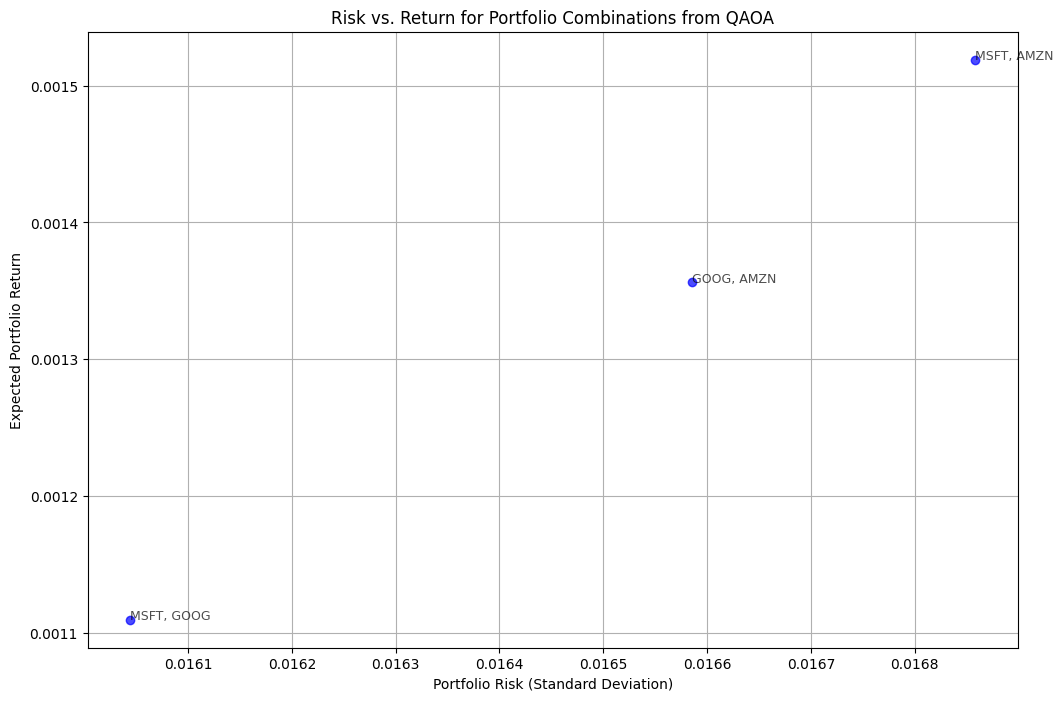

Optimal: selection [1. 0. 1.], value -0.0025

----------------- Full result ---------------------
Selection	Expected Return	Risk (Std. Dev.)	Probability	Stocks
---------------------------------------------------
101       	0.0015		0.0169		0.3339	MSFT, AMZN
110       	0.0014		0.0166		0.3334	GOOG, AMZN
011       	0.0011		0.0160		0.3327	MSFT, GOOG


In [10]:
def plot_qaoa_results(result, mu, sigma, tickers):
    probabilities = result.min_eigen_solver_result.eigenstate.binary_probabilities()
    weights_list = []
    returns = []
    risks = []
    annotations = []

    for binary_str, prob in probabilities.items():
        if prob > 0.01:  # Filter out very low probability solutions
            weights = np.array([int(bit) for bit in binary_str])[::-1]
            if np.sum(weights) == 0:
                continue  # Skip the zero-weight portfolio
            weights = weights / np.sum(weights)  # Normalize weights to sum to 1
            portfolio_return = np.dot(weights, mu)
            portfolio_risk = np.sqrt(np.dot(weights.T, np.dot(sigma, weights)))
            weights_list.append(weights)
            returns.append(portfolio_return)
            risks.append(portfolio_risk)
            included_tickers = [tickers[i] for i in range(len(tickers)) if weights[i] > 0]
            annotation = ', '.join(included_tickers)
            annotations.append(annotation)
            print(f"Allocation: {weights}, Return: {portfolio_return}, Risk: {portfolio_risk}, Probability: {prob}, Stocks: {annotation}")

    # Plotting the results with annotations
    plt.figure(figsize=(12, 8))
    scatter = plt.scatter(risks, returns, c='blue', marker='o', alpha=0.7)
    plt.xlabel('Portfolio Risk (Standard Deviation)')
    plt.ylabel('Expected Portfolio Return')
    plt.title('Risk vs. Return for Portfolio Combinations from QAOA')
    plt.grid(True)

    # Add annotations
    for i, annotation in enumerate(annotations):
        plt.annotate(annotation, (risks[i], returns[i]), fontsize=9, alpha=0.7)

    plt.show()
plot_qaoa_results(result, mu, sigma, data._tickers)
print_result(result, mu, sigma, data._tickers)

### Pip Packages

| Package                  | Version  |
|--------------------------|----------|
| `numpy`                  | 1.26.4   |
| `pandas`                 | 2.2.2    |
| `qiskit`                 | 1.1.0    |
| `qiskit-aqua`            | 1.1.0    |
| `qiskit-finance`         | 1.1.0    |
